# Continuous phase-type distribution of branch length

In [1]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

In [2]:
def plot_graph(gam, constrained=True, size='10'):

    constrained = constrained and 'true' or 'false'
    
    states, sim, ipv = np.array(gam[0]), np.array(gam[1]), np.array(gam[2])

    states = np.array(states)
    states = np.append(states, np.array([[9]*states.shape[1]]), axis=0)

    # add the missing row and col to SIM
    rates = np.r_[np.c_[sim, -sim.sum(axis=1)], np.zeros((1, len(sim)+1))]
    
    dot = Digraph()
    dot.node('S', 'S')
    dot.node(str(len(states)-1), 'Absorbing')    
    for i in range(0, len(states)-1):
        dot.node(str(i), str(states[i]))
    for i in range(len(ipv)):
        if ipv[i]:
            dot.edge('S', str(i), constraint=constrained, label=str(ipv[i]))
    for i in range(len(states)):
        for j in range(len(states)):
            if i != j and rates[i, j] > 0:
                dot.edge(str(i), str(j), constraint=constrained, label=str(rates[i, j]))
    dot.graph_attr['size'] = size                
    return dot

R header:

In [3]:
%%R
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Indlæser krævet pakke: usethis

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (0c1be222) has not changed since last install.
  Use `force = TRUE` to force installation



In [4]:
# %%R
# pkgbuild::check_build_tools(debug = TRUE)

# State space

## State space in R

In [5]:
# %%R -o graph -o states -o ipv -o sim


# r_construct_twolocus_island_graph <- function(s, N, M, R) {

#     # number of populations
#     p <- 2 # needs to be 2
#     # state vector length
#     n <- p*(s+1)**2

#     graph <- create_graph(n)
#     index <- 1
#     # first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
#     state <- rep(0, n)
#     state[conf_to_index(s, 1, 1, 1)] <- s
#     first_vertex <- create_vertex(graph, state) # assumes that p=2
#     add_edge(starting_vertex(graph), first_vertex, 1)

#     index <- 2
#     while (index <= vertices_length(graph)) {

#       vertex <- vertex_at(graph, index)
#       state <- vertex$state

#       count <- 0
#       for (i in 1:n) {
#           count <- count + state[i]
#       }
#       if (count <= 1) {
#           # Only one lineage, stop
#           index <- index + 1
#           next
#       }    

#       for (i in 1:n) {
#         conf_i <- index_to_conf(s, i)

#         # coalescence #########################
#         for (j in i:n) {
#           conf_j <- index_to_conf(s, j)

#           if (conf_i@population != conf_j@population) {
#             # different populations
#             next
#           }
#           if (i == j) {
#             if (state[i] < 2) {
#               next;
#             }
#             rate <- state[i] * (state[i] - 1) / 2 / N
#           } else {
#             if (state[i] < 1 || state[j] < 1) {
#               next;
#             }
#             rate <- state[i] * state[j] / N
#           }

#           child_state <- state

#           # lineages with index i and j coalesce:  
#           child_state[i] <- child_state[i] - 1
#           child_state[j] <- child_state[j] - 1
#           stopifnot(conf_i@locus1+conf_j@locus1 <= s)
#           stopifnot(conf_i@locus2+conf_j@locus2 <= s)

#           # coalescene into lineage with index k
#           k = conf_to_index(s, conf_i@locus1+conf_j@locus1, conf_i@locus2+conf_j@locus2, conf_i@population)
#           child_state[k] <- child_state[k] + 1

#           child_vertex <- find_or_create_vertex(graph, child_state)
#           add_edge(vertex, child_vertex, rate)
#         }

#         # recombination #######################
#         if (state[i] > 0 && conf_i@locus1 > 0 && conf_i@locus2 > 0) {

#           rate <- R
#           child_state <- state

#           # a lineage with index i recombines to produce lineages with index k and l
#           k = conf_to_index(s, conf_i@locus1, 0, conf_i@population)
#           l = conf_to_index(s, 0, conf_i@locus2, conf_i@population)
#           child_state[i] <- child_state[i] - 1
#           child_state[k] <- child_state[k] + 1
#           child_state[l] <- child_state[l] + 1

#           child_vertex <- find_or_create_vertex(graph, child_state)
#           add_edge(vertex, child_vertex, rate)
#         }

#         # migration ###########################
#         if (state[i] > 0) {

#           rate <- M
#           child_state <- state

#           if (conf_i@population == 1) {
#             m = 2
#           } else {
#             m = 1
#           }
#           # 
#           k = conf_to_index(s, conf_i@locus1, conf_i@locus2, m)
#           child_state[i] <- child_state[i] - 1
#           child_state[k] <- child_state[k] + 1

#           child_vertex <- find_or_create_vertex(graph, child_state)
#           add_edge(vertex, child_vertex, rate)
#         }
#       }

#       index <- index + 1

#       if ((index %% 50) == 0) {
#         cat(index, vertices_length(graph), "\n")
#       }

#     }
    
#     return(graph)
# }

# graph <- r_construct_twolocus_island_graph(2, 1, 0, 1)

# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state, simplify = FALSE))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

# graph_as_matrix(graph)

## State space in C

In [7]:
%%R
Rcpp::sourceCpp("./two_locus_two_island.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


Zero-probability transistions are ignored, so the state space is reduced when either recombination rate or migration rate are zero.

Each state has the following three properties:
1. nr decendants at locus 1
2. nr decendants at locus 2
3. what population the lineage is currently in

Rccp exports `construct_twolocus_island_graph`, `index_to_props`, and `props_to_index`:

Sample size:

In [8]:
%%R -o s
s <- 2

# Sanity checks without migration

## ARG TMRCA without migration

The minimum of two independent exponential random variables (the loci are independent with large recombination rate) with parameters $\lambda$ and $\eta$ is also exponential with parameter $\lambda+\eta$. Also:

$$\mathbb{E}[\min(X_1, X_2) + \max(X_1, X_2)] = \mathbb{E}[X_1 + X_2] = \frac{1}{\lambda} + \frac{1}{\eta}$$

Because 

$$\mathbb{E}[\min(X_1, X_2)] = \frac{1}{\lambda + \eta},$$

we get

$$\mathbb{E}[\min(X_1, X_2)] = \frac{1}{\lambda} + \frac{1}{\eta} - \frac{1}{\lambda + \eta}$$

So for a sample of two, and a coalescence rate of 1, the expected time to coalescence at *both* loci is $1 + 1 - \frac{1}{1+1} = 1.5$. The time for the two loci to coalesce is 1. So the total ARG TMRCA should be 2.5:

In [9]:
%%R
graph <- construct_twolocus_island_graph(2, 1, 1, 0, 0, 0)
expectation(graph)

[1] 1


INFO: building reward compute graph...


In [10]:
%%R
graph <- construct_twolocus_island_graph(2, 1, 1, 0, 0, 10000000)
expectation(graph)

[1] 2.5


INFO: building reward compute graph...


__*Note for Tobias*__: `expectation` does not like null-edges:

In [11]:
# %%R
# graph <- construct_twolocus_island_graph(2, 1, 1, 0, 0, 10000000, keep_null_edges=TRUE)
# expectation(graph)

## Visualize graph

In [12]:
%%R -o states -o parents -o children -o rates 
#-o locus1 -o locus2 -o pop

graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 1)

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))

parents <- c()
children <- c()
rates <- c()
for (i in 1:vertices_length(graph)) {
    for (edge in edges(vertex_at(graph, i))) {
        parents <- c(parents, i)
        children <- c(children, edge$child$index)
        rates <- c(rates, edge$weight)
    }
}

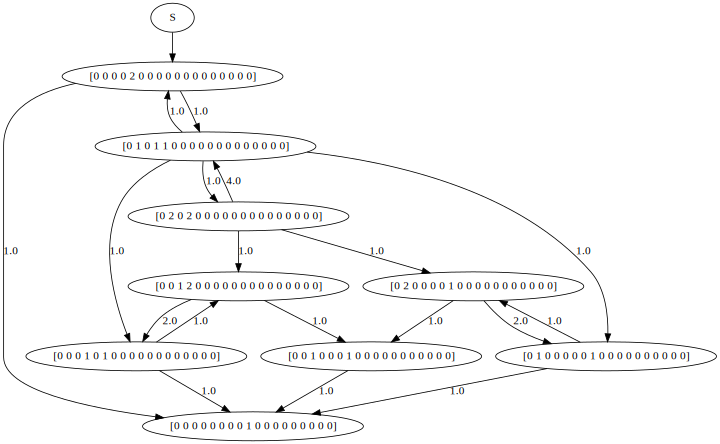

In [13]:
def plot_graph(states, parents, children, rates, constrained=True, size='10'):

    states = np.array(states)
    # states = list(zip(list(locus1[0]), list(locus2[0]) ))#, list(pop[0])))

    parents = [int(i-1) for i in parents]
    children = [int(i-1) for i in children]
    
    constrained = constrained and 'true' or 'false'
    
    dot = Digraph()
    dot.node('S', 'S')
    for i in range(1, len(states)):
        dot.node(str(i), str(states[i]))
    dot.edge('S', str(1))        
    for p, c, r in zip(parents, children, rates):
        if p > 0:
            dot.edge(str(p), str(c), constraint=constrained, label=str(r))

    dot.graph_attr['size'] = size                
    return dot

plot_graph(states, parents, children, rates)

In [14]:
%%R
index_to_props(s, 4)

$locus1
[1] 1

$locus2
[1] 0

$population
[1] 1



## Two-locus SFS without recombination

Expected ARG branches with i and j tons at each locus

In [15]:
%%R -o s -o exp_mat
s <- 4

graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 0)
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
print(vertices_length(graph))

exp_mat <- matrix(nrow=s+1,ncol=s+1)
for (i in 1:s) {
  for (j in 1:s) {
    exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
  }
}

[1] 6


INFO: building reward compute graph...


/Users/kmt/miniconda3/envs/phasetype/lib/python3.10/site-packages/matplotlib/colors.py:1253: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


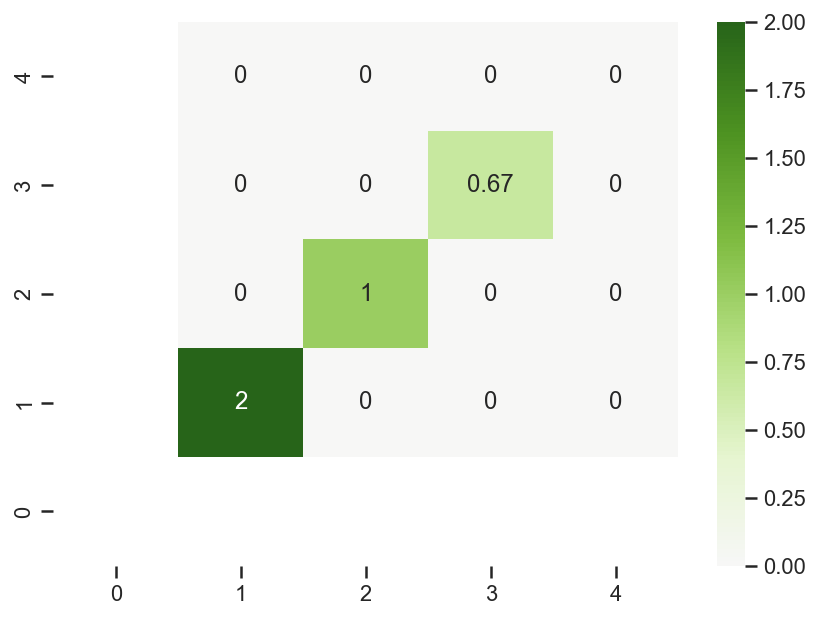

In [16]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(exp_mat, cmap="PiYG", 
                 center=0,
                annot=True
                )
ax.invert_yaxis()

## Two-locus SFS with recombination

Expected ARG branches with i and j tons at each locus

In [17]:
%%R -o s -o exp_mat
s <- 4

graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 2)
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
print(vertices_length(graph))

exp_mat <- matrix(nrow=s+1,ncol=s+1)
for (i in 0:s) {
  for (j in 0:s) {
    exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
  }
}

[1] 110


INFO: building reward compute graph...


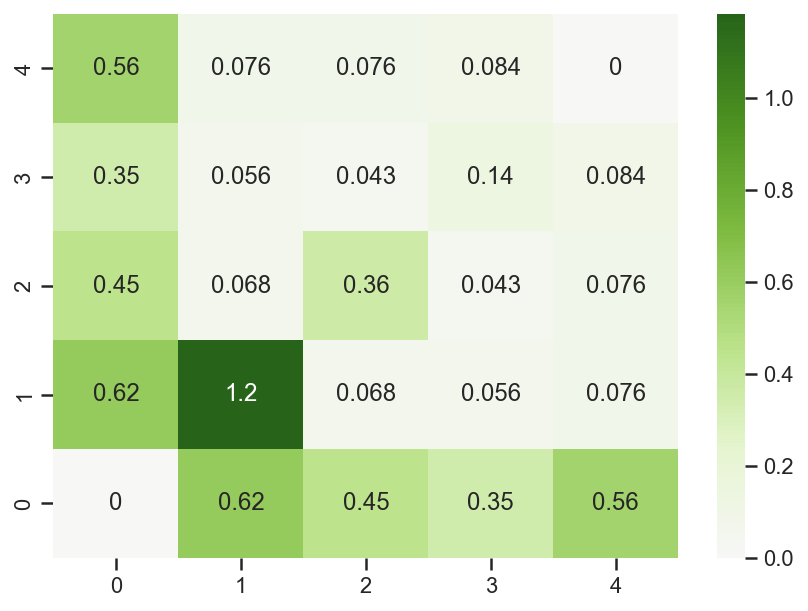

In [18]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(exp_mat, cmap="PiYG", 
                 center=0,
                  annot=True
                )
ax.invert_yaxis()

In [19]:
# plt.subplots(1, 1, figsize=(7, 5))
# ax = sns.heatmap(exp_mat, cmap="Reds")
# ax.invert_yaxis()

Marginal SFSs:

In [20]:
%%R -o sfs_locus1 -o sfs_locus2

sfs_locus1 <- colSums(exp_mat)
sfs_locus2 <- rowSums(exp_mat)

Fits expectations for a single locus:

In [21]:
sfs_locus1[1:-1] - np.array([2, 1, 2/3])

array([-2.22044605e-16, -5.55111512e-16, -5.55111512e-16])

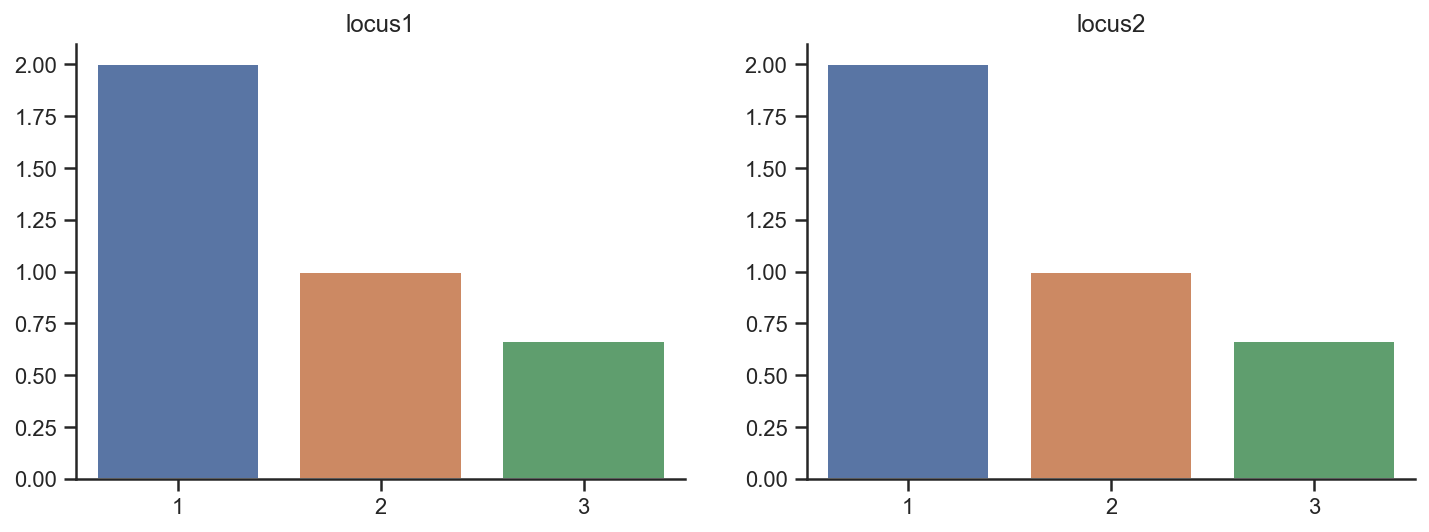

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(x=list(range(1, len(sfs_locus1)-1)), y=sfs_locus1[1:-1], ax=axes[0]).set_title("locus1")
sns.barplot(x=list(range(1, len(sfs_locus2)-1)), y=sfs_locus2[1:-1], ax=axes[1]).set_title("locus2")
sns.despine()

# PDFs of ARG branch length with i descendants at locus one and two at locus two

In [23]:
%%R -o result

result = data.frame()
for (i in 1:(s-1)) {
    for (j in 1:(s-1)) {
        x <- seq(from = 0, to = 5, by = 0.01)
        pdf <- dph(x, reward_transform(graph, rewards[props_to_index(s, i, j, 1),]))

        df <- data.frame(prob = pdf, t=x, i_ton=i, j_ton=j, color=100*j+i)
        result <- rbind(result, df)
    }
}
#result %>% ggplot(aes(y=prob, x=t, color=ton, group=ton)) + geom_line(size=1)

In [24]:
result

,prob,t,i_ton,j_ton,color
1,0.000000e+00,0.00,1,1,101.0
2,6.860333e-03,0.01,1,1,101.0
3,1.516116e-02,0.02,1,1,101.0
4,2.412523e-02,0.03,1,1,101.0
5,3.370150e-02,0.04,1,1,101.0
...,...,...,...,...,...
4505,3.819388e-07,4.96,3,3,303.0
4506,3.707805e-07,4.97,3,3,303.0
4507,3.599481e-07,4.98,3,3,303.0
4508,3.494322e-07,4.99,3,3,303.0


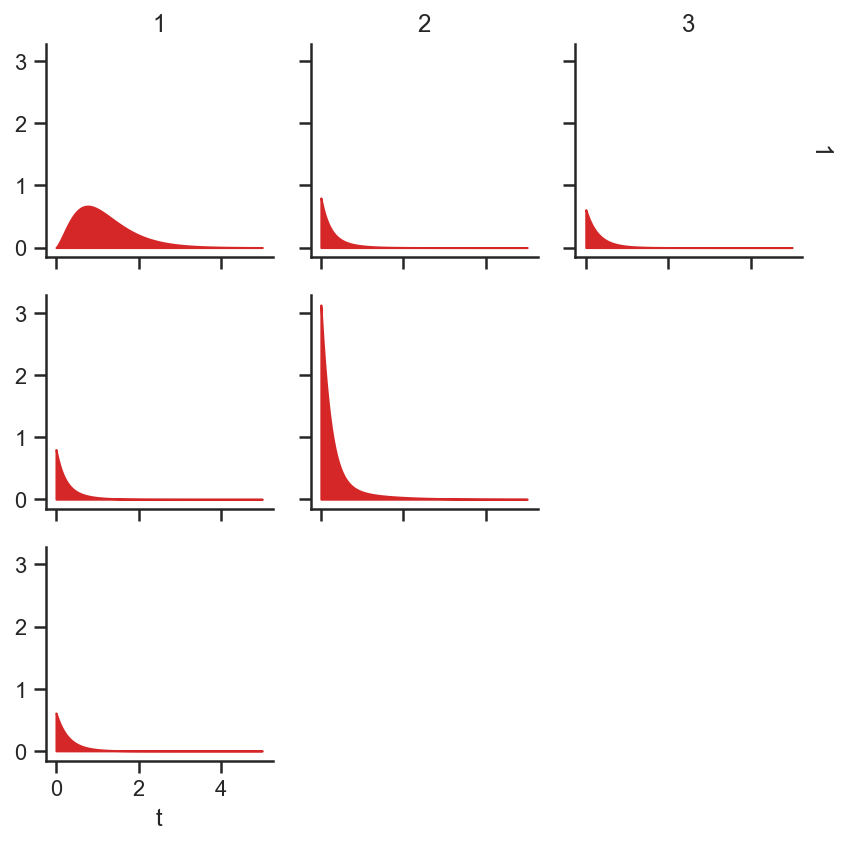

In [25]:
g = sns.FacetGrid(result, row='i_ton', col='j_ton', #hue='color',
            aspect=1, height=2, margin_titles=True, sharey=True)
g.map_dataframe(plt.fill_between, x="t", y1='prob', color='tab:red') ;
g.set_titles(row_template = '{row_name}', col_template = '{col_name}') ;

for row, axes in enumerate(g.axes):
    for col, ax in enumerate(axes):
        if col + row >= 3:
            ax.clear()
            ax.axis('off')
#            ax.set_xscale('log')

## ARG TMRCA without recombination

Test the classical result that with symmetric migration and sampling from one population, the expectation should be the sum of the two population sizes (2) and independent of the migration rate. The variance is not and should fall with higher migration rate and asymptotically reach (4):

In [26]:
%%R
graph <- construct_twolocus_island_graph(2, 1, 1, 10000000000, 10000000000, 0)
variance(graph)

[1] 4


INFO: building reward compute graph...


In [27]:
%%R -o mig_rates -o expectation_migrates -o variance_migrates
expectation_migrates <- c()
variance_migrates <- c()
mig_rates <- 10^(-5:5)
for (mig_rate in mig_rates) {
    graph <- construct_twolocus_island_graph(2, 1, 1, mig_rate, mig_rate, 0)
    expectation_migrates <- c(expectation_migrates, expectation(graph))
    variance_migrates <- c(variance_migrates, variance(graph))   
}

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


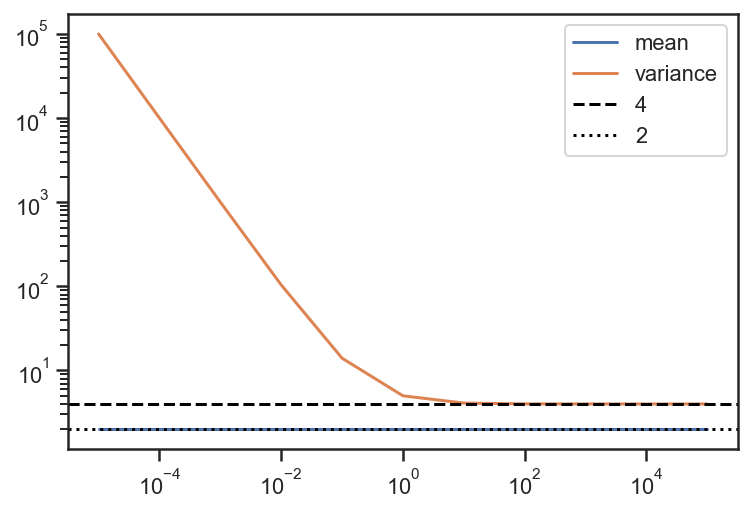

In [28]:
plt.plot(mig_rates, expectation_migrates, label='mean')
plt.plot(mig_rates, variance_migrates, label='variance')
plt.yscale('log')
plt.xscale('log')
plt.axhline(4, linestyle='dashed', color='black', label='4')
plt.axhline(2, linestyle='dotted', color='black', label='2')
plt.legend();

# Distribution of number of outgoing edes

In [29]:
%%R -o s
s <- 6

In [30]:
%%R -o outgoing_edge_counts
graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 1)
print(vertices_length(graph))
si <- sign(graph_as_matrix(graph)$SIM)
diag(si) <- 0
outgoing_edge_counts <- rowSums(si)
# qplot(outgoing_edge_counts)

[1] 1044


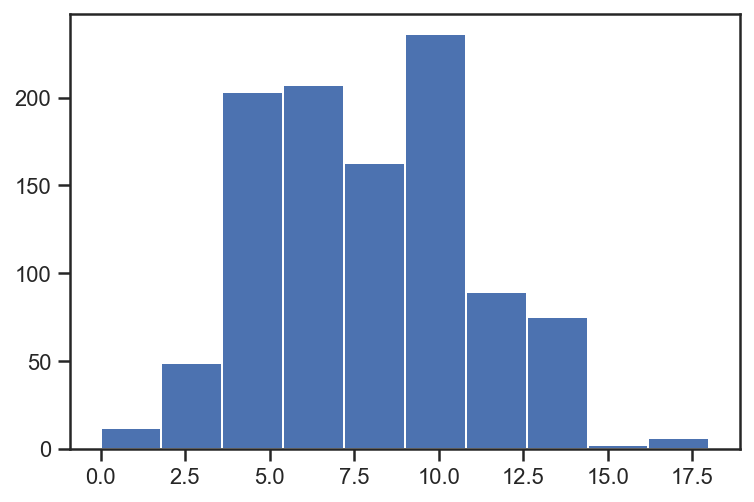

In [31]:
plt.hist(outgoing_edge_counts) ;

# Two-locus SFS

Expected ARG branches with i and j tons at each locus

In [32]:
# %%R -o s
# s <- 4

No migration:

In [33]:
# %%R
# graph <- construct_twolocus_island_graph(s, 1, 1, 1, 1, 1)
# rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
# vertices_length(graph)

In [34]:
# %%R

# library(foreach)
# foreach (i=1:3) %do% {
#   sqrt(i)
# }

In [35]:
%%R 
broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

two_locus_expectation <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    exp_mat <- matrix(nrow=s+1,ncol=s+1)
    for (i in 0:s) {
      for (j in 0:s) {
        exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
      }
    }
    return(exp_mat)
} 

In [36]:
%%R -o exp_mat
exp_mat <- two_locus_expectation(s, 1, 1, 1)
exp_mat

INFO: building reward compute graph...


          [,1]       [,2]       [,3]       [,4]       [,5]       [,6]      [,7]
[1,] 0.0000000 1.11414254 0.83875209 0.66236776 0.56096603 0.49571161 1.3170671
[2,] 1.1141425 2.06069441 0.10381944 0.07931653 0.05190836 0.04708094 0.1069803
[3,] 0.8387521 0.10381944 0.76137927 0.08150143 0.06143870 0.03696461 0.1063918
[4,] 0.6623678 0.07931653 0.08150143 0.38358502 0.05768776 0.04077732 0.1066635
[5,] 0.5609660 0.05190836 0.06143870 0.05768776 0.21917256 0.04321406 0.1149075
[6,] 0.4957116 0.04708094 0.03696461 0.04077732 0.04321406 0.14602283 0.1255997
[7,] 1.3170671 0.10698025 0.10639182 0.10666349 0.11490751 0.12559967 0.0000000


In [37]:
# %%R -o exp_mat
# exp_mat <- matrix(nrow=s+1,ncol=s+1)
# for (i in 0:s) {
#   for (j in 0:s) {
#     exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
#   }
# }

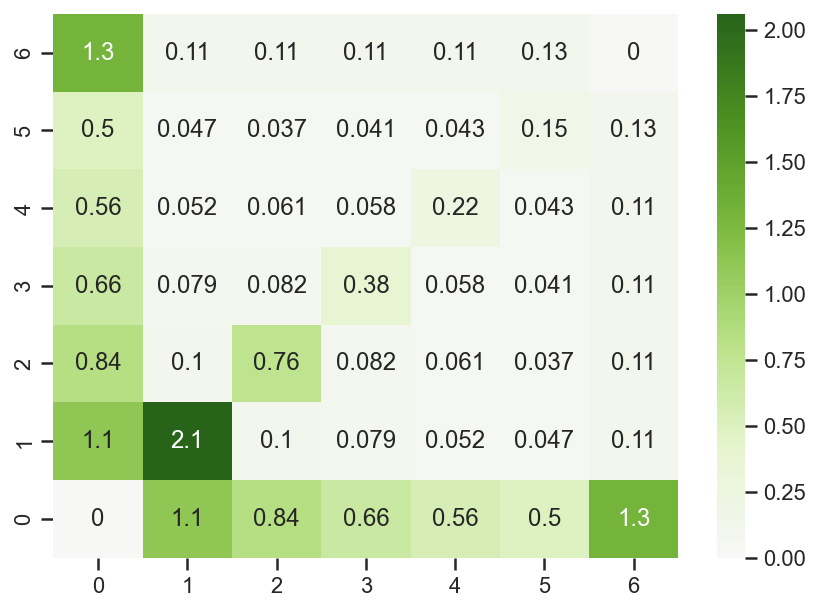

In [38]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(exp_mat, cmap="PiYG", 
                 center=0,
                annot=True
                )
ax.invert_yaxis()

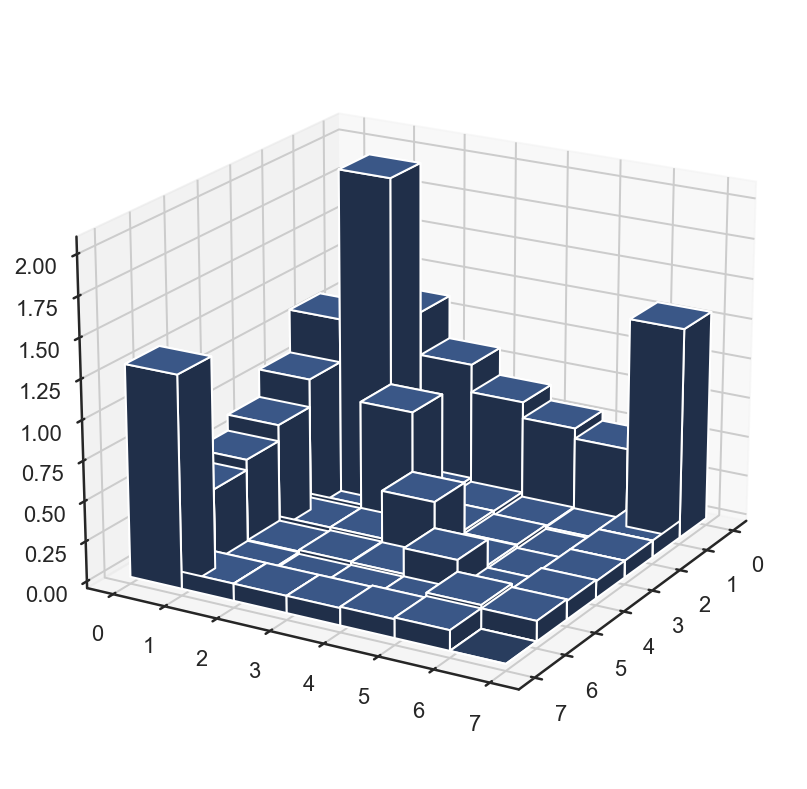

In [39]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111, projection='3d')

_x = np.arange(s+1)
_y = np.arange(s+1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
top = exp_mat.flatten()
bottom = np.zeros_like(top)
width = depth = 1
ax1.view_init(20, 30)
ax1.bar3d(x, y, bottom, width, depth, top, shade=True) ;

# Covriance between tons at locus one

In [40]:
%%R

broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

ton_covariance_within_locus <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(graph, locus1_rewards(i), locus1_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
}    

No migration and no recombination:

In [41]:
%%time
%%R -o cov_mat_no_mig
cov_mat_no_mig <- ton_covariance_within_locus(s, 1, 0, 0) 

CPU times: user 67.1 ms, sys: 3.78 ms, total: 70.9 ms
Wall time: 35.9 ms


INFO: building reward compute graph...


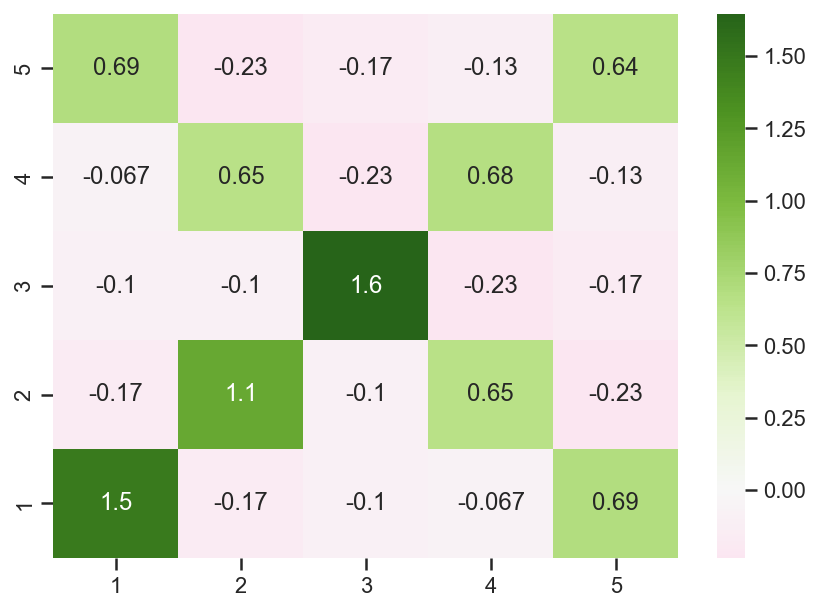

In [42]:
plt.subplots(1, 1, figsize=(7, 5))
ticks = list(range(1,int(s)))
ax = sns.heatmap(cov_mat_no_mig, cmap="PiYG", 
                annot=True,
                center=0,
                yticklabels=ticks,
                xticklabels=ticks
                )
ax.invert_yaxis()

# Covriance between tons between loci

In [43]:
%%R

broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

ton_covariance_between_loci <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }
    locus2_rewards <- function(j) {
        colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(graph, locus1_rewards(i), locus2_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
}    

No migration and no recombination:

In [44]:
%%R -o cov_mat_no_rec_no_mig
cov_mat_no_rec_no_mig <- ton_covariance_between_loci(s, 1, 0, 0) 


INFO: building reward compute graph...


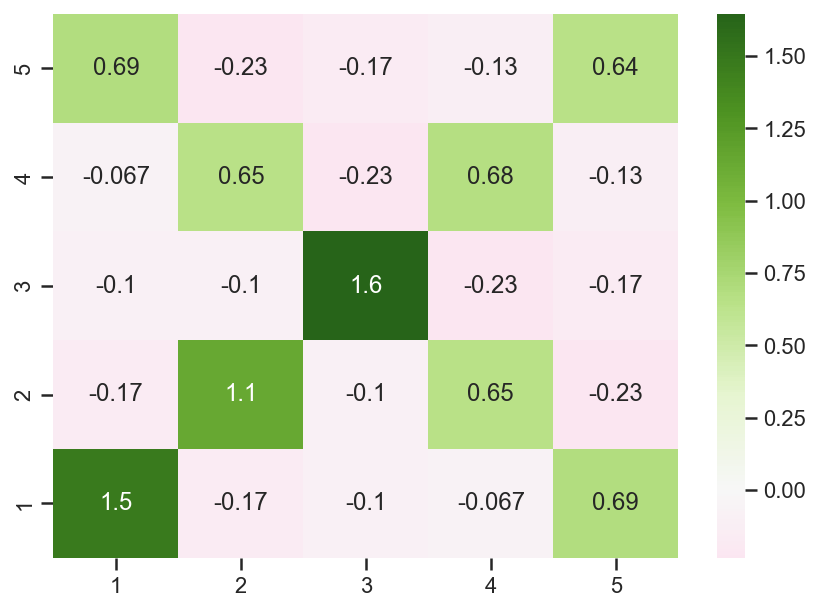

In [45]:
plt.subplots(1, 1, figsize=(7, 5))
ticks = list(range(1,int(s)))
ax = sns.heatmap(cov_mat_no_rec_no_mig, cmap="PiYG", 
                annot=True,
                center=0,
                yticklabels=ticks,
                xticklabels=ticks
                )
ax.invert_yaxis()

With recombination:

In [46]:
#%%R -o cov_mat_no_mig

In [47]:
# plt.subplots(1, 1, figsize=(7, 5))
# ticks = list(range(1,int(s)))
# ax = sns.heatmap(cov_mat_no_mig, cmap="PiYG", 
#                 annot=True,
#                 center=0,
#                 yticklabels=ticks,
#                 xticklabels=ticks
#                 )
# ax.invert_yaxis()

In [48]:
%%R -o cov_mat_low_rec -o cov_mat_no_mig
cov_mat_no_mig <- ton_covariance_between_loci(s, 1, 0, 1) 
cov_mat_low_rec <- ton_covariance_between_loci(s, 1, 0, 0.1) 

INFO: building reward compute graph...
INFO: building reward compute graph...


In [49]:
%%R -o cov_mat_mig
cov_mat_mig <- ton_covariance_between_loci(s, 1, 0.1, 1) 

INFO: building reward compute graph...


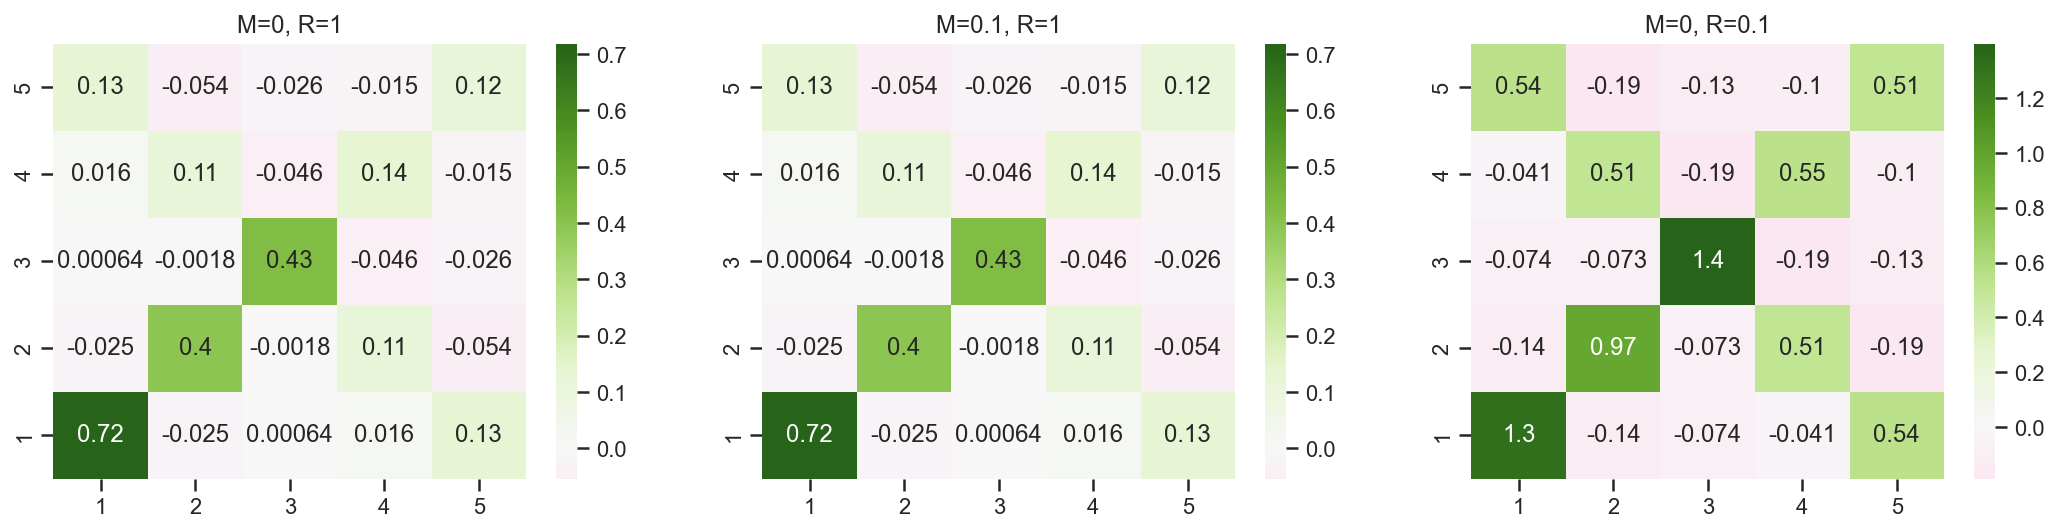

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
ticks = list(range(1,int(s)))
ax = sns.heatmap(cov_mat_no_mig, cmap="PiYG", annot=True, center=0,
                yticklabels=ticks, xticklabels=ticks, ax=axes[0])
ax.invert_yaxis()
ax.set_title('M=0, R=1')

ax = sns.heatmap(cov_mat_no_mig, cmap="PiYG", annot=True, center=0,
                yticklabels=ticks, xticklabels=ticks, ax=axes[1])
ax.invert_yaxis()
ax.set_title('M=0.1, R=1') ;

ax = sns.heatmap(cov_mat_low_rec, cmap="PiYG", annot=True, center=0,
                yticklabels=ticks, xticklabels=ticks, ax=axes[2])
ax.invert_yaxis()
ax.set_title('M=0, R=0.1') ;

# Covariance of ARG branches in the two populations

Covariance of two-locus "ton" branch length (e.g. singletons at locus 1 and doubletons at locus 2) spent in each population.

In [51]:
%%R
graph <- construct_twolocus_island_graph(s, 1, 1, 1, 1, 1)
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

In [52]:
%%R -o cov_mat
fun <- function(a, b) mapply(function(i, j) covariance(graph, rewards[props_to_index(s, i, j, 1),], rewards[props_to_index(s, i, j, 2),]), a, b)
cov_mat <- outer(1:(s-1), 1:(s-1), fun)

INFO: building reward compute graph...


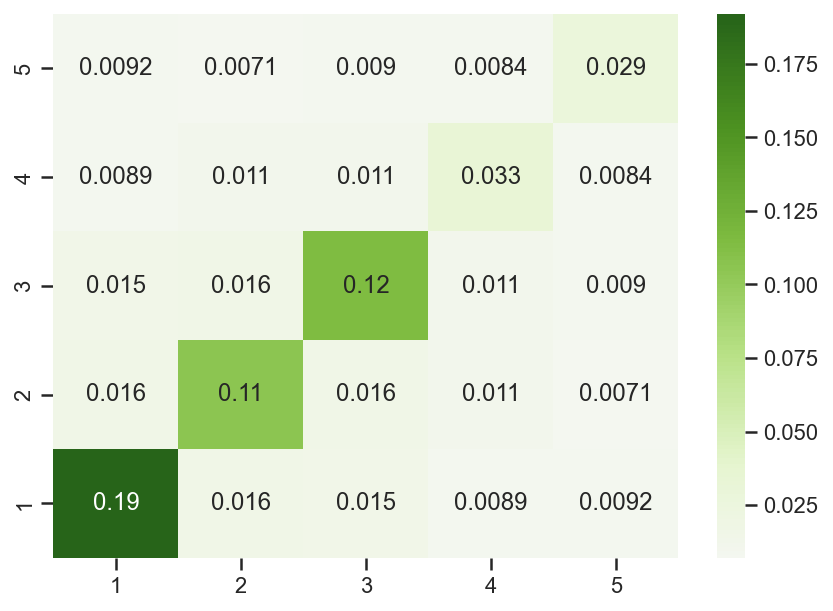

In [53]:
plt.subplots(1, 1, figsize=(7, 5))
ticks = list(range(1,int(s)))
ax = sns.heatmap(cov_mat, cmap="PiYG", 
                 center=0,
                yticklabels=ticks,
                xticklabels=ticks,
                annot=True
                )
ax.invert_yaxis()

Shows that when there are hte same number of decendants at each locus (mostly becuase of no recombination) then the covariance is highest. Mostly for small tons where there are many lineages to back and forth between popoulations.

In [54]:
# %%R

# setClass("conf", slots=list(locus1="numeric", locus2="numeric", population="numeric"))

# obj <- new("conf", locus1=3, locus2=2, population=1)
# obj@population

# r_index_to_props <- function(s, i) {
#     #' returns the locus1, locus2, population
#     #' conformation of lineages represented by
#     #' state vector index i.
#     stopifnot(i > 0)
#     d <- s + 1 # dim
#     idx <- i - 1
#     p <- idx %/% d**2
#     stopifnot(i <= 2*d**2)
#     a <- (idx - p*d**2) %/% d
#     b <- (idx - p*d**2) %% d
#     return(new("conf", locus1=a, locus2=b, population=p+1))
# }
# r_props_to_index <- function(s, a, b, p) {
#     #' returns the state vector index representing
#     #' the locus1, locus2, population conformation.
#     d <- s + 1
#     i = (p-1)*d**2 + a*d + b + 1
#     return(i)
# }

In [55]:
%%R -o fit_mat -o n -o m

s <- 4
expected_cov_mat <- ton_covariance_between_loci(s, 1, 0.5, 2)
# expected_cov_mat <- (expected_cov_mat - mean(expected_cov_mat)) / sd(expected_cov_mat)

expected_exp_mat <- two_locus_expectation(s, 1, 0.5, 2)
# expected_exp_mat <- (expected_exp_mat - mean(expected_exp_mat)) / sd(expected_exp_mat)


fit <- function(N, M) {
    observed_cov_mat <- ton_covariance_between_loci(s, N, M, 2)
    # observed_cov_mat <- (observed_cov_mat - mean(observed_cov_mat)) / sd(observed_cov_mat)
    
    observed_exp_mat <- two_locus_expectation(s, N, M, 2)
    # observed_exp_mat <- (observed_exp_mat - mean(observed_exp_mat)) / sd(observed_exp_mat)
    
    cov_fit <- abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat, na.rm=TRUE))
    exp_fit <- abs(sum((observed_exp_mat - expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
    return(exp_fit + cov_fit)
}

n <- seq(0.5, 1.5, 0.05)
m <- seq(0.1, 1.1, 0.05)
params <- expand.grid(n, m)
fit_mat <- matrix(mapply(fit, params$Var1, params$Var2), nrow=length(n),ncol=length(m))

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

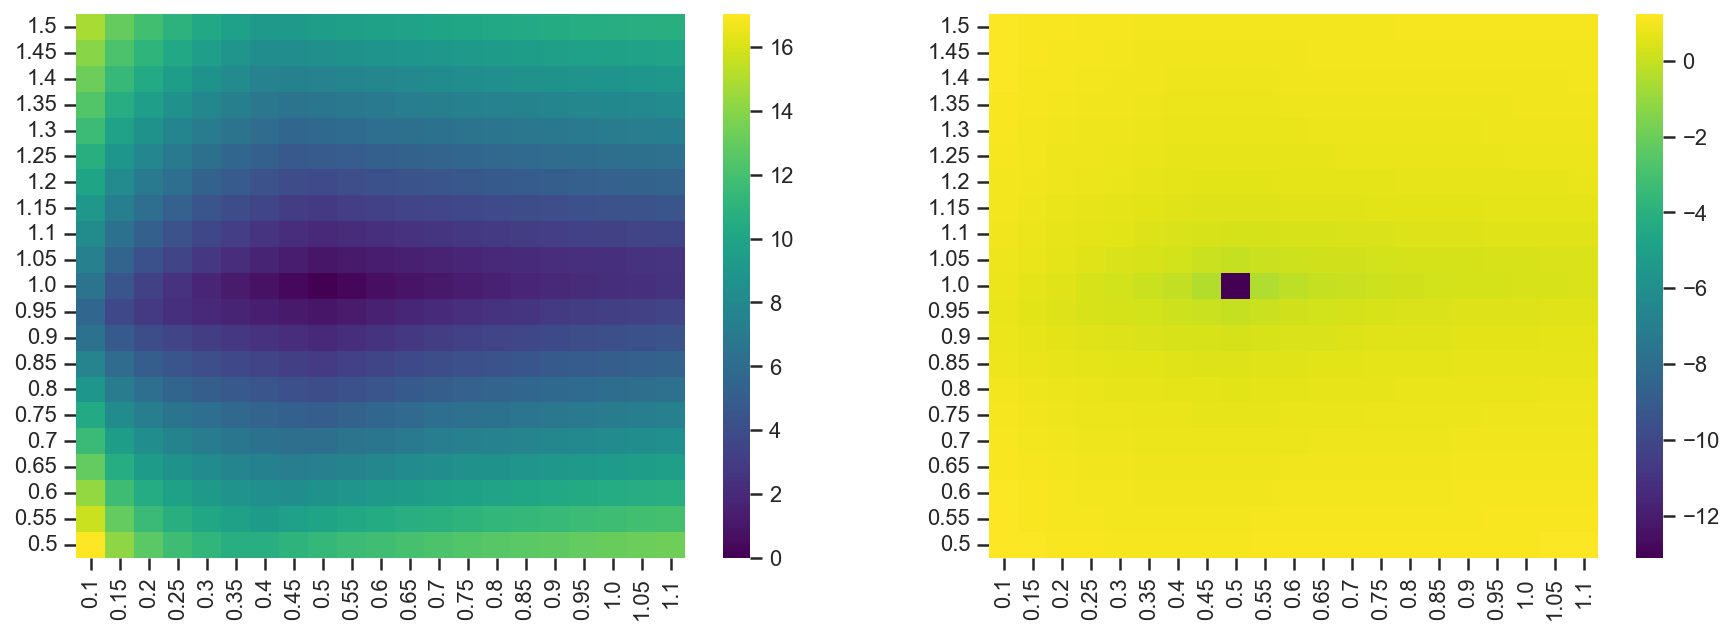

In [56]:
plot_df = pd.DataFrame(fit_mat, columns=np.round(m, 2), index=np.round(n, 2))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
g = sns.heatmap(plot_df, cmap="viridis", ax=ax1)
ax1.invert_yaxis()
plot_df.where(plot_df <= 0, np.nan)
g = sns.heatmap(np.log10(plot_df), cmap="viridis", ax=ax2)
ax2.invert_yaxis()

## Multiprocessing

In [57]:
%%R -o fit_mat -o n -o m

library(parallel)

apply_grid <- function(fun, a, b) {
    named_params <- expand.grid(a, b)
    param_list <- split(named_params, seq(nrow(named_params)))    
    result_list <- mclapply(param_list, function(x) do.call(fit, as.list(as.vector(unlist(x)))), mc.cores=4L)
    fit_mat <- matrix(unlist(result_list), nrow=length(a),ncol=length(b))
    return(fit_mat)
}

s <- 4
expected_cov_mat <- ton_covariance_between_loci(s, 1, 0.5, 2)
expected_exp_mat <- two_locus_expectation(s, 1, 0.5, 2)


# fit <- function(N, M) {
#     observed_cov_mat <- ton_covariance_between_loci(s, N, M, 2)
#     return( abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat)) )
# }
n <- seq(0.5, 2.5, 0.05)
m <- seq(0.01, 2.01, 0.05)
fit_mat <- apply_grid(fit, n, m)

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

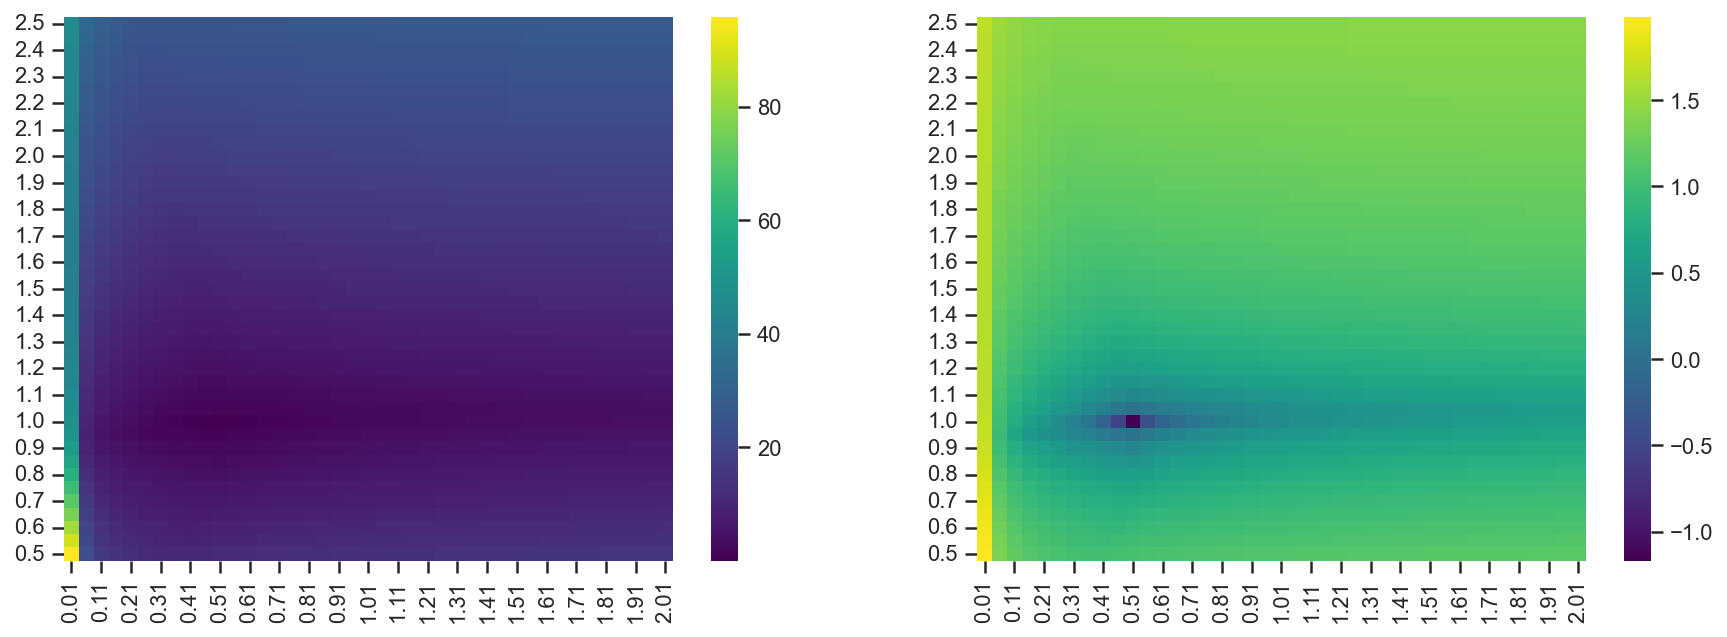

In [58]:
plot_df = pd.DataFrame(fit_mat, columns=np.round(m, 2), index=np.round(n, 2))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
g = sns.heatmap(plot_df, cmap="viridis", ax=ax1)
ax1.invert_yaxis()
plot_df.where(plot_df <= 0, np.nan)
g = sns.heatmap(np.log10(plot_df), cmap="viridis", ax=ax2)
ax2.invert_yaxis()
plt.savefig('fit2.pdf', bbox_inches='tight')